In [345]:
import ML.preprocessing as preprocessing
import ML.linearModels as linearModels
import ML.measurements as measurements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline  

# 1. Opening data

In [346]:
#Open data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

#set the index to the ID
df_train = df_train.set_index('Id');
df_test = df_test.set_index('Id');

In [347]:
COLUMNS = df_train.columns

In [348]:
#put together all data that we have, this will make it easier to produce one-hot vectors, etc.
TARGET = ['SalePrice']
FEATURES = list(set(COLUMNS) - set(TARGET))
df_all = pd.concat((df_train[FEATURES],df_test[FEATURES]))

In [349]:
#Finally it is potentially useful to seperate out the different columns labels (i.e. features)
NUMERICAL = np.array(['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1',\
             'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',\
            'GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',\
                      'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF',\
                      'OpenPorchSF','EnclosedPorch'\
             ,'3SsnPorch','ScreenPorch','PoolArea','MiscVal'])
YEARS = np.array(['YearBuilt','YearRemodAdd','YrSold','GarageYrBlt'],dtype = 'U25')
TARGET = ['SalePrice']

CATEGORICAL = set(COLUMNS) - set(NUMERICAL)
CATEGORICAL -= set(YEARS)
CATEGORICAL -= set(TARGET)
CATEGORICAL = np.array(list(CATEGORICAL))


#A quick check that this works out:
COLUMN_UNION = set(NUMERICAL).union(set(YEARS)).union(set(CATEGORICAL))
if set(COLUMNS) - COLUMN_UNION == set(TARGET):
    print('column seperation works out')

column seperation works out


# 2. Dealing with NULLS

We are required to deal with null values via the three columns type above:
1. Numerical values (NUMERICAL) - the nulls will need to filled in a context dependent manner. 
2. Categorical values (CATEGORICAL) - the nulls will largely be given their own category in a contextual manner subject to the data description(i.e. sometimes NA means 'None'
3. Date values (YEARS).

### 2.1 NUMERICAL

In [350]:
def nullsByColTypes(COL_TYPE):
    df_nulls = df_all[COL_TYPE].isnull().sum()
    return df_nulls[df_nulls > 0]

In [351]:
nullsByColTypes(NUMERICAL)

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageCars        1
GarageArea        1
dtype: int64

In [352]:
#Since these are all related to the structure of the house - we make the assumption that these depend on the 
#neighbourhood, and subjected to the median (and thus existing) architecture.

NUMERICAL_NAN_INDICES = nullsByColTypes(NUMERICAL).index 
for COLS in NUMERICAL_NAN_INDICES:
    df_all[COLS] = df_all.groupby(['Neighborhood'])[COLS].transform(lambda x: x.fillna(x.median()))

#Quick check that this fills the nulls accordingly
nullsByColTypes(NUMERICAL).empty

True

### 2.2 CATEGORICAL

In [353]:
nullsByColTypes(CATEGORICAL)

KitchenQual        1
BsmtFinType1      79
Fence           2348
Exterior2nd        1
MasVnrType        24
Utilities          2
Alley           2721
MiscFeature     2814
GarageQual       159
Functional         2
BsmtExposure      82
GarageFinish     159
FireplaceQu     1420
MSZoning           4
BsmtCond          82
GarageType       157
PoolQC          2909
Electrical         1
GarageCond       159
BsmtFinType2      80
SaleType           1
BsmtQual          81
Exterior1st        1
dtype: int64

In [354]:
#There are categories data columns where NA is meaningful in the sense that it means 'None'. This can be infered
#from the data description.
NONE_COLS = ['Alley','MasVnrType','BsmtFinType1','MiscFeature','GarageFinish','FireplaceQu','PoolQC','BsmtCond'\
        ,'GarageQual','Fence','BsmtExposure','BsmtQual','BsmtFinType2','GarageCond','GarageType']

df_all[NONE_COLS] = df_all[NONE_COLS].transform(lambda x:x.fillna('None'))

In [355]:
nullsByColTypes(CATEGORICAL)

KitchenQual    1
Exterior2nd    1
Utilities      2
Functional     2
MSZoning       4
Electrical     1
SaleType       1
Exterior1st    1
dtype: int64

In [356]:
#The remaining categorical data is simply nan due to unreconisable reasons, they are therefore set to the mode:
INDICES = nullsByColTypes(CATEGORICAL).index

for REM_COLS in INDICES:
    df_all[REM_COLS] = df_all[REM_COLS].fillna(df_all[REM_COLS].mode()[0])
    
#Quick check that this fills the nulls accordingly
nullsByColTypes(CATEGORICAL).empty

True

### 2.3 YEARS

In [357]:
nullsByColTypes(YEARS)

GarageYrBlt    159
dtype: int64

In [358]:
#Question : Is there a good reason there are null?
#Consider data pertitnent to the garage
GARAGE = ['GarageYrBlt','GarageType','GarageFinish','GarageCars','GarageArea','GarageQual','GarageCond']
df_garage = df_all[GARAGE]
df_nan_garage = df_garage[df_garage['GarageYrBlt'].isnull()]

#There are null values for GarageYrBlt which is because a garage does not exist AND those which are simply null.
df_nan_garage_None = df_nan_garage[df_nan_garage['GarageType'] == 'None']
df_nan_garage_notNone = df_nan_garage[df_nan_garage['GarageType'] != 'None']

In [359]:
#For those values of GarageYrBlt which are null due to no existing garage
df_all.loc[df_nan_garage_None.index,'GarageYrBlt'] \
= df_all.loc[df_nan_garage_None.index,'GarageYrBlt'].transform(lambda x:x.fillna(0));

In [360]:
nullsByColTypes(YEARS)

GarageYrBlt    2
dtype: int64

In [361]:
#The remaining is set to zero also
df_all.loc[df_nan_garage_notNone.index,'GarageYrBlt'] \
= df_all.loc[df_nan_garage_notNone.index,'GarageYrBlt'].transform(lambda x:x.fillna(0));

In [362]:
nullsByColTypes(YEARS).empty

True

### 2.4 Final NULL analysis

In [363]:
nullsByColTypes(df_all.columns).empty

True

# 3. Dealing with skew data

As we shall see much of the data is skewed and since a fundamental assumption of linear models are normally distributed variables we solve this.

In [364]:
df_all.skew()

3SsnPorch        11.381914
LotFrontage       1.506478
GarageYrBlt      -3.908213
FullBath          0.167692
GrLivArea         1.270010
EnclosedPorch     4.005950
ScreenPorch       3.948723
WoodDeckSF        1.843380
PoolArea         16.907017
MoSold            0.195985
BedroomAbvGr      0.326492
BsmtHalfBath      3.933616
YearBuilt        -0.600114
YearRemodAdd     -0.451252
OpenPorchSF       2.536417
2ndFlrSF          0.862118
LotArea          12.829025
GarageArea        0.241916
HalfBath          0.694924
GarageCars       -0.217611
MasVnrArea        2.611228
TotRmsAbvGrd      0.758757
OverallQual       0.197212
TotalBsmtSF       1.163409
BsmtFullBath      0.625153
1stFlrSF          1.470360
BsmtUnfSF         0.920064
LowQualFinSF     12.094977
YrSold            0.132467
BsmtFinSF1        1.426128
BsmtFinSF2        4.148275
MSSubClass        1.376165
Fireplaces        0.733872
MiscVal          21.958480
OverallCond       0.570605
KitchenAbvGr      4.304467
dtype: float64

In [365]:
df_train[TARGET].skew()

SalePrice    1.882876
dtype: float64

Clearly very skew data...


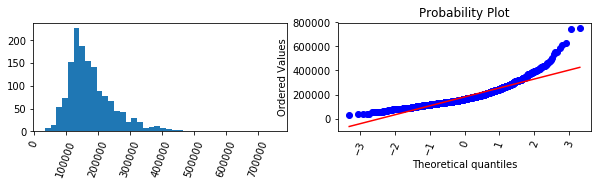

Clearly slightly more normalised data...


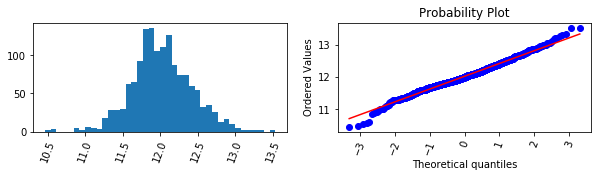

In [366]:
#Let us unskew the target varible:

X = df_train[TARGET].as_matrix().ravel()
print('Clearly very skew data...')
fig , axs = plt.subplots(1,2,figsize=(10,2))
plt.setp( axs[0].xaxis.get_majorticklabels(), rotation=70)
a = axs[0].hist(X,bins = 40)
plt.setp( axs[1].xaxis.get_majorticklabels(), rotation=70 )

scipy.stats.probplot(X, dist="norm", plot=plt)
plt.show(axs[1])

print('Clearly slightly more normalised data...')
X = np.log1p(X)
fig , axs = plt.subplots(1,2,figsize=(10,2))
plt.setp( axs[0].xaxis.get_majorticklabels(), rotation=70)
a = axs[0].hist(X,bins = 40)
plt.setp( axs[1].xaxis.get_majorticklabels(), rotation=70 )

scipy.stats.probplot(X, dist="norm", plot=plt)
plt.show(axs[1])

In [367]:
df_train[TARGET] = np.log1p(df_train[TARGET])
df_train[TARGET].skew()

SalePrice    0.121347
dtype: float64

In [368]:
skew = df_all[NUMERICAL].skew()
SKEWED_COLS = skew[abs(skew) > 0.75].index

In [369]:
df_all[SKEWED_COLS] = np.log(1+df_all[SKEWED_COLS])

# 4. Changing categorical data into one-hot vectors

In [370]:
#Make use of a function from the ML implementation.
NEWCATEGORICAL ,df_all = preprocessing.fromCatergoricalToOneHot(CATEGORICAL,[df_all])
df_all = df_all[0]

In [371]:
#Recheck column count
COLUMNS = df_all.columns
COLUMN_UNION = set(NUMERICAL).union(set(YEARS)).union(set(NEWCATEGORICAL))
if set(COLUMNS) - COLUMN_UNION == set():
    print('column seperation works out')

column seperation works out


# 5. Modelling

### 5.1 Validation sets

In [372]:
X_train = df_all[:df_train.shape[0]]
X_test = df_all[df_train.shape[0]:]
y = df_train.SalePrice
train = pd.concat([X_train,y],axis = 1)

In [373]:
valSets = preprocessing.split(train,0.2)

train/test split with 20.0 resampled as test data
There are 5 sets


In [374]:
#to demonstrate how valSets works:
print('valSets is a dictionary')
print('valSets keys are the sets themselves:',valSets.keys())
print('Consider a key 1 : itself a dictionary with keys',valSets[1].keys())


print('shape of training set :',valSets[1]['train'].shape)
print('shape of testing set :',valSets[1]['test'].shape)

valSets is a dictionary
valSets keys are the sets themselves: dict_keys([1, 2, 3, 4, 5])
Consider a key 1 : itself a dictionary with keys dict_keys(['test', 'train'])
shape of training set : (1168, 346)
shape of testing set : (292, 346)


In [375]:
#Validation scheme works as follows:

#1) Separate into various sets for cross validation, train on each (X_train,y_train), test on (X_test,y_test).
FEATURES = np.array(list(X_train.columns))

X_train_set = [valSets[i]['train'][FEATURES].as_matrix() for i in list(valSets.keys())]
y_train_set = [valSets[i]['train'][TARGET].as_matrix() for i in list(valSets.keys())]

X_test_set = [valSets[i]['test'][FEATURES].as_matrix() for i in list(valSets.keys())]
y_test_set = [valSets[i]['test'][TARGET].as_matrix() for i in list(valSets.keys())]

#2) create a model performance function, which tests of the RMSLE, root mean square log error. 
#This is taken from ML.measurements.

def modelPerformance(model,ravelRequired = False):
    metrics = measurements.measurements()
    performance = []
    for i in range(0,len(X_train_set)):
        model.fit(X_train_set[i],y_train_set[i].ravel())
        result = model.predict(X_test_set[i])
        performance.append(metrics.RMSLE(result,y_test_set[i]))
    return np.array(performance).mean()



### 5.2 Scoring individual models

#### Basic Linear Regression

In [376]:
from sklearn import linear_model
model_lm = linear_model.LinearRegression()
modelPerformance(model_lm)

0.04757080798841219

#### Ridge Regression

In [377]:
alphas = np.linspace(0.05,0.30,100)
models = [linear_model.Ridge(alpha) for alpha in alphas]
listOfModelPerformance = np.array([np.array([modelPerformance(model),model.alpha]) for model in models])

In [378]:
perform = dict()
for x in listOfModelPerformance:
    perform[x[0]] = x[1]

In [379]:
lowest = min(perform.keys())
print(lowest)
alpha_star = perform[min(perform.keys())]
model_ridge = linear_model.Ridge(alpha_star)

0.04651177204040826


#### Random Forest

In [380]:
from sklearn.ensemble import RandomForestRegressor
model_tree = RandomForestRegressor(max_depth=300, n_estimators=500, max_features = 300, oob_score=True, random_state=213)
modelPerformance(model_tree,True)

0.044060777724285065

#### Lasso Regression

In [381]:
alphas = np.linspace(10,40,200)
models = [linear_model.Lasso(alpha) for alpha in alphas]
listOfModelPerformance = np.array([np.array([modelPerformance(model),model.alpha]) for model in models])

In [382]:
perform = dict()
for x in listOfModelPerformance:
    perform[x[0]] = x[1]

lowest = min(perform.keys())
print(lowest)
alpha_star = perform[min(perform.keys())]
model_lasso = linear_model.Lasso(alpha_star)


0.033757370216290654


### 5.3 Taking combinations of models (Stacking)

In [383]:
models = [model_tree,model_lasso,model_ridge,model_lm]

res = []
for i in range(0,len(X_train_set)):
    tempRes = []
    for model in models:
        model.fit(X_train_set[i],y_train_set[i].ravel())
        tempRes.append(model.predict(X_test_set[i]))
    res.append(tempRes)

'res' is the complete prediction of all four models considered across all data points in the test data, i.e. the predictions can be arranged in a dataframe

In [386]:
m1 = []
m2 = []
m3 = []
m4 = []

for i in range(5):
    m1.append(res[i][0])
    m2.append(res[i][1])
    m3.append(res[i][2])
    m4.append(res[i][3])
    
m1 = np.array(m1).ravel()
m2 = np.array(m2).ravel()
m3 = np.array(m2).ravel()
m4 = np.array(m2).ravel()

Y = np.array(y_test_set).ravel()

model_df = pd.DataFrame(data = {'Tree':m1,'Lasso':m2,'Ridge':m3,'Linear':m4,'RESULT':Y})

We thus have four simple models and a test result. We seek a linear combination of the four models that produce the test result - this is once again an OLS exercise:

In [387]:
model_df.head()

,Lasso,Linear,RESULT,Ridge,Tree
0,11.959420,11.959420,11.794345,11.959420,11.808429
1,12.047359,12.047359,11.626263,12.047359,11.795879
2,12.110362,12.110362,12.751303,12.110362,12.752871
3,12.124082,12.124082,11.373675,12.124082,11.788852
4,12.013792,12.013792,12.312687,12.013792,12.290193


In [388]:
modelValSets = preprocessing.split(model_df,0.2)

train/test split with 20.0 resampled as test data
There are 5 sets


We know repeat the exercise of finding the best model for the second level phase.

In [389]:
#Validation scheme works as follows:

#1) Separate into various sets for cross validation, train on each (X_train,y_train), test on (X_test,y_test).
FEATURES = np.array(['Tree','Lasso','Ridge','Linear'])
TARGET = ['RESULT']

X_train_set = [modelValSets[i]['train'][FEATURES].as_matrix() for i in list(modelValSets.keys())]
y_train_set = [modelValSets[i]['train'][TARGET].as_matrix() for i in list(modelValSets.keys())]

X_test_set = [modelValSets[i]['test'][FEATURES].as_matrix() for i in list(modelValSets.keys())]
y_test_set = [modelValSets[i]['test'][TARGET].as_matrix() for i in list(modelValSets.keys())]

#2) create a model performance function, which tests of the RMSLE, root mean square log error. 
#This is taken from ML.measurements.

def modelPerformance(model,ravelRequired = False):
    metrics = measurements.measurements()
    performance = []
    for i in range(0,len(X_train_set)):
        model.fit(X_train_set[i],y_train_set[i].ravel())
        result = model.predict(X_test_set[i])
        performance.append(metrics.RMSLE(result,y_test_set[i]))
    return np.array(performance).mean()


#### Basic Linear Regression

In [390]:
from sklearn import linear_model
model2_lm = linear_model.LinearRegression()
modelPerformance(model2_lm)

0.045309448544336016

# 6. Model Summary

We have two layers, the first layers contains four models:

1. Linear Regression (model_lm)
2. Lasso Regression (model_lasso)
3. Random Forest (model_tree)
4. ridge Regression (model_ridge)

The second layers takes the result of these first four models to produce the result, the model is:
1. Linear regression (model2_lm)

In [391]:
model_lasso.fit(X_train,y)
model_tree.fit(X_train,y)
model_ridge.fit(X_train,y)
model_lm.fit(X_train,y)

y_lasso = model_lasso.predict(X_train)
y_tree = model_tree.predict(X_train)
y_ridge = model_ridge.predict(X_train)
y_lm = model_lm.predict(X_train)

In [392]:
dfX = pd.DataFrame(data = {'tree':y_tree,'lasso':y_lasso,'ridge':y_ridge,'linear':y_lm})

In [393]:
model2_lm.fit(dfX,y)
train_res = model2_lm.predict(dfX)

In [394]:
y_lasso = model_lasso.predict(X_test)
y_tree = model_tree.predict(X_test)
y_ridge = model_ridge.predict(X_test)
y_lm = model_lm.predict(X_test)

In [395]:
dfXTEST = pd.DataFrame(data = {'tree':y_tree,'lasso':y_lasso,'ridge':y_ridge,'linear':y_lm})

In [396]:
result = np.expm1(model2_lm.predict(dfXTEST))

# printing result

In [397]:
df = pd.DataFrame(data  = {'SalePrice':result},index = X_test.index)
df.to_csv('result.csv')

In [398]:
df

,SalePrice
Id,
1461,120556.029685
1462,159504.530519
1463,187017.972047
1464,185895.277603
1465,191408.238442
1466,185609.803992
1467,171839.089070
1468,177688.622514
1469,181991.980268
